In [1]:
import pathlib
import matplotlib.pyplot as plt
from c3.parametermap import ParameterMap
from utils import *
from c3.experiment import Experiment
import c3.libraries.constants as constants

2021-08-17 14:02:12.440566: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-17 14:02:12.440601: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [20]:
# plotting functions
def plotOccupations(
        experiment: Experiment,
        populations: np.array,
        gate_sequence: List[str],
        level_names: List[str] = None,
        filename: str = None,
) -> None:
    """
    Plots time dependent populations. They need to be calculated with `runTimeEvolution` first.

    Parameters
    ----------
    experiment: Experiment
        The experiment containing the model and propagators
    populations: np.array
        Population vector for each time step
    gate_sequence: List[str]
        List of gate names that will be applied to the state
    level_names: List[str]
        Optional list of names for the levels. If none, the default list
        from the experiment will be used.
    filename: str
        Optional name of the file to which the plot will be saved. If none,
        it will only be shown.

    Returns
    -------

    """
    # plot populations
    fig, axs = plt.subplots(1, 1)
    dt = experiment.ts[1] - experiment.ts[0]
    ts = np.linspace(0.0, dt * populations.shape[1], populations.shape[1])
    axs.plot(ts / 1e-9, populations.T)

    # plot vertical lines
    gate_steps = [experiment.partial_propagators[g].shape[0] for g in gate_sequence]
    for i in range(1, len(gate_steps)):
        gate_steps[i] += gate_steps[i - 1]
    gate_times = gate_steps * dt
    plt.vlines(gate_times / 1e-9, tf.reduce_min(populations), tf.reduce_max(populations),
               linestyles=':', colors="black")

    # set plot properties
    axs.tick_params(direction="in", left=True, right=True, top=False, bottom=True)
    axs.set_xlabel('Time [ns]')
    axs.set_ylabel('Population')
    plt.legend(level_names if level_names else model.state_labels)
    plt.tight_layout()

    # show and save
    if filename:
        print("saving plot in " + filename)
        plt.savefig(filename)
    else:
        plt.show()
    plt.close()


def plotSignal(time, signal, filename=None, spectrum_cut=1e-4) -> None:
    """
    Plots a time dependent signal and its normalised frequency spectrum.

    Parameters
    ----------
    time
        timestamps
    signal
        signal value
    filename: str
        Optional name of the file to which the plot will be saved. If none,
        it will only be shown.
    spectrum_cut:
        If not None, only the part of the normalised spectrum will be plotted
        whose absolute square is larger than this value.

    Returns
    -------

    """
    # plot time domain
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].set_title('Signal')
    axs[0].plot(time, signal)
    axs[0].set_xlabel('time')

    # calculate frequency spectrum
    n_samples = time.shape[-1]
    freq_signal = np.fft.rfft(signal)
    normalised = freq_signal / np.max(freq_signal)
    freq = np.fft.rfftfreq(n_samples, time[-1] / n_samples)

    # cut spectrum if necessary
    if spectrum_cut is not None:
        limits = np.flatnonzero(np.abs(normalised) ** 2 > 1e-4)
        freq = freq[limits[0]:limits[-1]]
        normalised = normalised[limits[0]:limits[-1]]

    # plot frequency domain
    axs[1].set_title('Spectrum')
    axs[1].plot(freq, normalised.real, label="Re")
    axs[1].plot(freq, normalised.imag, label="Im")
    axs[1].plot(freq, np.abs(normalised) ** 2, label="Square")
    axs[1].set_xlabel('frequency')
    axs[1].legend()

    # show and save
    plt.tight_layout()
    if filename:
        print("saving plot in " + filename)
        plt.savefig(filename)
    else:
        plt.show()
    plt.close()

In [3]:
# preparation
occupied_levels = [0]
directory = "./output"
output_dir = pathlib.Path(directory)
output_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# model
q1 = createQubit(1, 5, 5e9, -300e6)
model = createModel([q1])
generator = createGenerator(model)

2021-08-17 14:02:19.404045: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-08-17 14:02:19.404743: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-17 14:02:19.405231: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-17 14:02:19.405349: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost.localdomain): /proc/driver/nvidia/version does not exist
2021-08-17 14:02:19.407246: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [5]:
# gate
envelope = createGaussianPulse(7e-9)
ideal = constants.X
gate = createSingleQubitGate("lower-X", 7e-9, 5e9, envelope, model, q1, ideal)
gates = [gate]
gate_names = list(map(lambda g: g.get_key(), gates))

# experiment
exp = Experiment(pmap=ParameterMap(instructions=gates, model=model, generator=generator))
exp.set_opt_gates(gate_names)
unitaries = exp.compute_propagators()
print('unitaries: ', dict(map(lambda kv: (kv[0], kv[1].numpy().shape), unitaries.items())))

# initial state
init_state = createState(model, occupied_levels)
state = init_state.numpy().flatten()
print("initial state=", state, ", occupation=", exp.populations(state, model.lindbladian).numpy())

2021-08-17 14:02:21.726700: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-17 14:02:21.744356: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2793465000 Hz


unitaries:  {'lower-X[0]': (5, 5)}
initial state= [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j] , occupation= [1. 0. 0. 0. 0.]


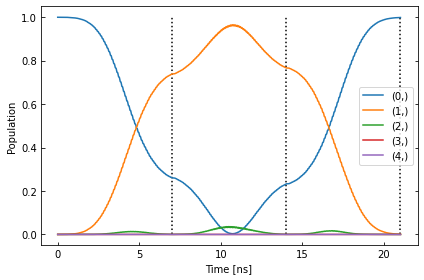

In [16]:
sequence = ["lower-X[0]"] * 3
populations = runTimeEvolutionDefault(exp, init_state, sequence)
plotOccupations(exp, populations, sequence)

In [21]:
signal = generator.generate_signals(gate)[getDrive(model, q1).name]
plotSignal(signal['ts'], signal['values'], directory + "/signal_before.png", spectrum_cut=1e-4)

saving plot in ./output/signal_before.png
